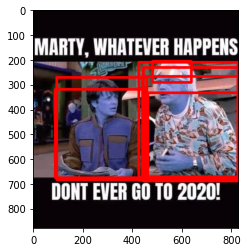

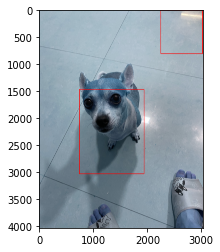

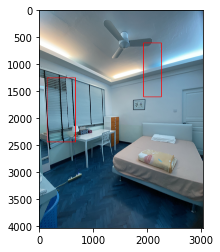

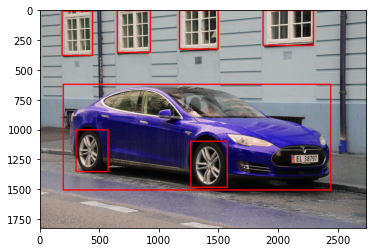

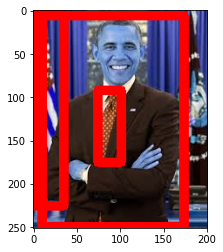

In [53]:
from google.cloud import vision
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import sys
from bounding_box import bounding_box as bb
import cv2

import pandas as pd
import seaborn as sns
from google.cloud import storage
import argparse


def localize_objects(path, log=False):
    """Localize objects in the local image.

    Arguments
    ---------
    path: str
    
    Return
    ------
    coordinate : list
    """
    
    # Create vision client. 
    client = vision.ImageAnnotatorClient()

    # Load image file. 
    with open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.types.Image(content=content)

    # Call API.
    objects = client.object_localization(
        image=image).localized_object_annotations

    if log:
        print('Number of objects found: {}'.format(len(objects)))

    object_number = len(objects)

    # Extract and formatting data from objects into dictionary.
    coordinates = []
    for object_ in objects:
        
        object_coordinate = []
        for vertex in object_.bounding_poly.normalized_vertices:
            object_coordinate.append((vertex.x, vertex.y))
         
        coordinates.append({
            "label": object_.name,
            "score": object_.score,
            "coordinate": object_coordinate,
        })
        
    return coordinates


def draw_rectangle(image_path, coordinates, log=False):
    """Draw rectangle on the photo.
    
    Arguments
    ---------
    image_path : str
    coordinate : list
    log        : bool    
    """

    # Read img and img size with cv2.
    cv2_image = cv2.imread(image_path)
    img_height, img_width, channels = cv2_image.shape

    for c in coordinates:
        if log:
            print("label      : ", c["label"])
            print("coordinate : ", c["coordinate"])

        # Set start_point/end_point and denormalize values. 
        start_point = int(c["coordinate"][0][0]*img_width), int(c["coordinate"][0][1]*img_height)
        end_point = int(c["coordinate"][2][0]*img_width), int(c["coordinate"][2][1]*img_height)

        color = (255, 0, 0)
        thickness = 10
        
        drawn_image = cv2.rectangle(cv2_image, start_point, end_point, color, thickness)

    plt.imshow(drawn_image)
    plt.show()
    rect_image = None
    
    
if __name__ == "__main__":

    image_files = [
        "../images/back_to_the_future.jpeg",
        "../images/dog.jpeg",
        "../images/singapore_room.jpeg",
        "../images/sports_car.jpg",
        "../images/obama.jpeg"
    ]

    image_path = image_files[4]
    for image_path in image_files:
        coordinates = localize_objects(image_path)
        draw_rectangle(image_path, coordinates)